In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
! pip install -U accelerate
! pip install -U transformers
!pip install peft

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 33.0 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.35.2
    Uninstalling transformers-4.35.2:
      Successfully uninstalled transformers-4.35.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.3/168.3 kB 4.0 MB/s eta 0:00:00


In [28]:
import pandas as pd
import numpy as np
import accelerate
import transformers
from transformers import (

    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    XLNetTokenizerFast,
    XLNetForSequenceClassification,
    BertTokenizerFast,
    BertForSequenceClassification,
    AlbertTokenizerFast,
    AlbertForSequenceClassification,
    RobertaTokenizerFast,
    RobertaForSequenceClassification,

    Trainer,
    TrainingArguments
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from transformers import EarlyStoppingCallback
import torch

In [4]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

In [5]:
def compute_metrics(p):
    pred, labels = p

    auc_roc = roc_auc_score(y_true=labels, y_score=pred)

    return {"auc_roc": auc_roc}

#DistilBert

In [6]:
train_data = pd.read_csv("/content/drive/MyDrive/llm2/train_drcat_04.csv")
test_data = pd.read_csv("/content/drive/MyDrive/llm-detect-ai-generated-text/test_essays.csv")
#train = pd.read_csv('/content/drive/MyDrive/LLM/train_essays.csv')

In [ ]:
from peft import LoraConfig, TaskType
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification
from peft import get_peft_config, PeftModel, PeftConfig, get_peft_model, LoraConfig, TaskType
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from pathlib import Path
from transformers import BitsAndBytesConfig
from transformers import EarlyStoppingCallback

model_name = "roberta-base"
tokenizer = RobertaTokenizerFast.from_pretrained(model_name)
model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=1)

peft_config = LoraConfig(
    r=64,
    lora_alpha=1,
    target_modules=["query","key", "value"],
    lora_dropout=0.01,
    task_type="SEQ_CLS",
    inference_mode=False,
)

peft_model = get_peft_model(model, peft_config)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )
print_trainable_parameters(peft_model)

trainable params: 4130305 || all params: 128776706 || trainable%: 3.2073386005074553


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from peft import get_peft_config, PeftModel, PeftConfig, get_peft_model, LoraConfig, TaskType
from pathlib import Path
from transformers import BitsAndBytesConfig
from transformers import EarlyStoppingCallback


model_name = "distilbert-base-cased"
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)

model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=1)


peft_config = LoraConfig(
    r=64,
    lora_alpha=1,
    target_modules=["q_lin","k_lin", "v_lin"],   #모델마다 다르므로 print 모델해서 모듈 이름 확인
    lora_dropout=0.01,
    task_type="SEQ_CLS",
    inference_mode=False,
)

peft_model = get_peft_model(model, peft_config)

X = list(train_data["text"])
y = list(train_data["label"])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)

train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)

args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="steps",
    eval_steps=500,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    seed=0,
    logging_steps=10,
    load_best_model_at_end = True
)

trainer = Trainer(
    model=peft_model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

trainer.train()

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Auc Roc
500,0.069800,0.071522,0.991144
1000,0.037800,0.050273,0.996123
1500,0.025000,0.036401,0.996899
2000,0.024600,0.024027,0.997305
2500,0.017300,0.031110,0.997421
3000,0.017000,0.022542,0.997596
3500,0.020000,0.018487,0.997694
4000,0.020300,0.014637,0.997877
4500,0.027100,0.020830,0.998009
5000,0.010600,0.016754,0.998161


TrainOutput(global_step=7000, training_loss=0.026387253785505892, metrics={'train_runtime': 1500.4188, 'train_samples_per_second': 70.708, 'train_steps_per_second': 8.84, 'total_flos': 7823621984722944.0, 'train_loss': 0.026387253785505892, 'epoch': 1.58})

In [ ]:
trainer.model.save_pretrained('model')
!zip -r /content/model.zip /content/model

tokenizer.save_pretrained('token')
!zip -r /content/token.zip /content/token

  adding: content/model/ (stored 0%)
  adding: content/model/adapter_config.json (deflated 47%)
  adding: content/model/adapter_model.bin (deflated 7%)
  adding: content/model/README.md (deflated 66%)
  adding: content/token/ (stored 0%)
  adding: content/token/tokenizer_config.json (deflated 76%)
  adding: content/token/special_tokens_map.json (deflated 42%)
  adding: content/token/vocab.txt (deflated 49%)
  adding: content/token/tokenizer.json (deflated 70%)


In [ ]:
tokenizer.save_pretrained('/content/drive/MyDrive/LLM Parameter/lora')

#모델 예측

In [ ]:
import torch.nn.functional as F

X_test = list(test_data["text"])

#tokenizer = DistilBertTokenizerFast.from_pretrained("/content/drive/MyDrive/LLM Parameter/Distilbert/distilbert/model.safetensors")
X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)

# Create torch dataset
test_dataset = Dataset(X_test_tokenized)

# Load trained model
#model_path = "/content/drive/MyDrive/LLM Parameter/Distilbert/distilbert/model.safetensors"
#model =DistilBertForSequenceClassification.from_pretrained(model_path, num_labels=1)

# Define test trainer
test_trainer = Trainer(model)

# Make prediction
raw_pred, _, _ = test_trainer.predict(test_dataset)

test_pred = (torch.tensor(raw_pred)).numpy().ravel()
print(test_pred)

[0.01876952 0.01453518 0.01487168]


#Bert

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from pathlib import Path
from transformers import BitsAndBytesConfig
from transformers import EarlyStoppingCallback
from transformers import BertTokenizerFast, BertForSequenceClassification

model_name = "bert-base-uncased"
tokenizer = BertTokenizerFast.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=1)

print(model)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from peft import get_peft_config, PeftModel, PeftConfig, get_peft_model, LoraConfig, TaskType
from pathlib import Path
from transformers import BitsAndBytesConfig
from transformers import EarlyStoppingCallback
from peft import LoraConfig, TaskType
from transformers import BertTokenizerFast, BertForSequenceClassification

model_name = "bert-base-uncased"
tokenizer = BertTokenizerFast.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=1)

peft_config = LoraConfig(
    r=64,
    lora_alpha=1,
    target_modules=["query", "key", "value"],
    lora_dropout=0.01,
    task_type="SEQ_CLS",
    inference_mode=False,
)

peft_model = get_peft_model(model, peft_config)

X = list(train_data["text"])
y = list(train_data["label"])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)

train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)

args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="steps",
    eval_steps=500,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    seed=0,
    logging_steps=10,
    load_best_model_at_end = True
)

trainer = Trainer(
    model=peft_model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

trainer.train()

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Auc Roc
500,0.073600,0.073975,0.985437
1000,0.029700,0.045026,0.995573
1500,0.034200,0.031617,0.996914
2000,0.031400,0.033485,0.996995
2500,0.020700,0.023238,0.996952
3000,0.023700,0.049150,0.995797
3500,0.017500,0.039052,0.993222
4000,0.011700,0.026472,0.996272


TrainOutput(global_step=4000, training_loss=0.044375636398792266, metrics={'train_runtime': 1576.9096, 'train_samples_per_second': 67.278, 'train_steps_per_second': 8.411, 'total_flos': 8767446122496000.0, 'train_loss': 0.044375636398792266, 'epoch': 0.9})

In [ ]:
trainer.model.save_pretrained('model')
!zip -r /content/model_unbert_lora.zip /content/model

tokenizer.save_pretrained('token')
!zip -r /content/token_unbert_lora.zip /content/token

  adding: content/model/ (stored 0%)
  adding: content/model/README.md (deflated 66%)
  adding: content/model/adapter_config.json (deflated 47%)
  adding: content/model/adapter_model.bin (deflated 7%)
  adding: content/token/ (stored 0%)
  adding: content/token/tokenizer.json (deflated 71%)
  adding: content/token/vocab.txt (deflated 53%)
  adding: content/token/special_tokens_map.json (deflated 42%)
  adding: content/token/tokenizer_config.json (deflated 76%)


Custom Dataset 예측

In [ ]:
import zipfile
import os

# Replace 'your_path' with the path where you have the zip file
zip_file_path = '/content/drive/MyDrive/LLM Parameter/Bert/fine_tuned_tokenizer.zip'
extract_folder = '/content/'

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

# Replace 'your_path' with the path where you have the zip file
zip_file_path = '/content/drive/MyDrive/LLM Parameter/Bert/fine_tuned_model.zip'
extract_folder = '/content/'

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained("/content/content/fine_tuned_Token")
Chat_test = list(merged_df["text"])

# Tokenize the test data
chat_test_tokenized = tokenizer(Chat_test, padding=True, truncation=True, max_length=512)

# Create torch dataset
chat_test_dataset = Dataset(chat_test_tokenized)

# Load the trained model using AutoModelForSequenceClassification
model_path = "/content/content/fine_tuned_model"
model = BertForSequenceClassification.from_pretrained(model_path, num_labels=1, ignore_mismatched_sizes=True)

# Define the test trainer
test_trainer = Trainer(model)

# Make predictions
raw_pred = test_trainer.predict(chat_test_dataset).predictions

# Apply sigmoid activation if necessary
test_pred1 = (torch.tensor(raw_pred)).numpy().ravel()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /content/content/fine_tuned_model and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([1, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROC AUC test: 1.0
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


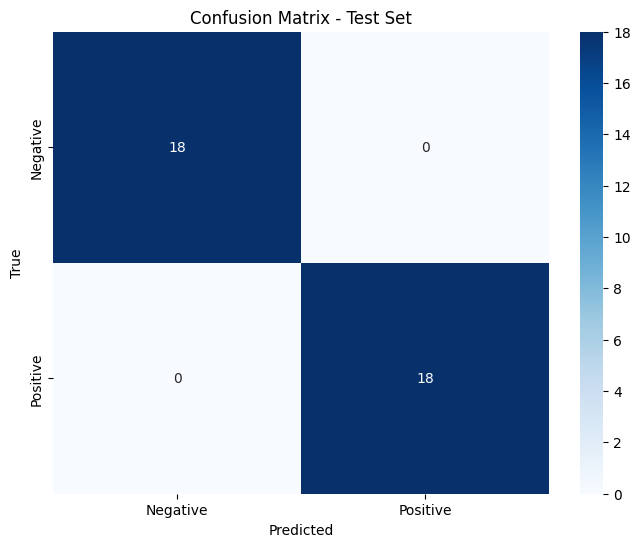

In [ ]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the test set
preds_test = test_pred1
y_test_vectors = merged_df['label']

# Generate confusion matrix
fpr, tpr, thresholds = roc_curve(y_test_vectors, preds_test)
roc_auc = auc(fpr, tpr)

# You can choose a threshold based on your requirements, for example, maximizing the F1 score
optimal_threshold = thresholds[np.argmax(tpr - fpr)]

# Convert probabilities to binary predictions using the optimal threshold
binary_preds_test = (preds_test >= optimal_threshold).astype(int)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_vectors, binary_preds_test)

# Calculate additional metrics
accuracy = accuracy_score(y_test_vectors, binary_preds_test)
precision = precision_score(y_test_vectors, binary_preds_test)
recall = recall_score(y_test_vectors, binary_preds_test)
f1 = f1_score(y_test_vectors, binary_preds_test)

# Print metrics
print('ROC AUC test:', roc_auc)
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Test Set')
plt.show()

#XLnet_train

In [ ]:
import wandb
wandb.init(project='LLM')

# 실행 이름 설정
wandb.run.name = 'XLnet'
wandb.run.save()

wandb: Currently logged in as: iuapink0522. Use `wandb login --relogin` to force relogin


wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


True

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from peft import get_peft_config, PeftModel, PeftConfig, get_peft_model, LoraConfig, TaskType
from pathlib import Path
from transformers import BitsAndBytesConfig
from transformers import EarlyStoppingCallback
from peft import LoraConfig, TaskType
from transformers import XLNetTokenizerFast, XLNetForSequenceClassification

model_name = "xlnet-base-cased"
tokenizer =  XLNetTokenizerFast.from_pretrained(model_name)
model = XLNetForSequenceClassification.from_pretrained(model_name, num_labels=1)

print(model)

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0-11): 12 x XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (activation_function): GELUActivation()
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (sequence_summary): SequenceSummary(
    (summary): Linear(in_features=768, out_features=768, bias=True)
    (activation): Tanh()
    (first_dropout): Identity()
    (last

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from peft import get_peft_config, PeftModel, PeftConfig, get_peft_model, LoraConfig, TaskType
from pathlib import Path
from transformers import BitsAndBytesConfig
from transformers import EarlyStoppingCallback
from peft import LoraConfig, TaskType

model_name = "xlnet-base-cased"
tokenizer =  XLNetTokenizerFast.from_pretrained(model_name)
model = XLNetForSequenceClassification.from_pretrained(model_name, num_labels=1)

peft_config = LoraConfig(
    r=64,
    lora_alpha=1,
    target_modules=["layer_1", "layer_2"],
    lora_dropout=0.01,
    task_type="SEQ_CLS",
    inference_mode=False,
)
peft_model = get_peft_model(model, peft_config)

X = list(train_data["text"])
y = list(train_data["label"])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)

train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)

args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="steps",
    eval_steps=500,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    seed=0,
    logging_steps=10,
    load_best_model_at_end = True
)

trainer = Trainer(
    model=peft_model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

trainer.train()

In [ ]:
model_save_path = "/content/drive/MyDrive/LLM Parameter/xlnet"
trainer.save_model(model_save_path)

config_save_path = '/content/drive/MyDrive/LLM Parameter/xlnet'
model.config.save_pretrained(config_save_path)

custom dataset

In [ ]:
import zipfile
import os

# Replace 'your_path' with the path where you have the zip file
zip_file_path = '/content/drive/MyDrive/LLM Parameter/XLnet.zip'
extract_folder = '/content/'

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

In [ ]:
tokenizer = XLNetTokenizerFast.from_pretrained("/content/file_tokenizer_4/content/xlnet_1")
Chat_test = list(merged_df["text"])

# Tokenize the test data
chat_test_tokenized = tokenizer(Chat_test, padding=True, truncation=True, max_length=512)

# Create torch dataset
chat_test_dataset = Dataset(chat_test_tokenized)

# Load the trained model using AutoModelForSequenceClassification
model_path = "/content/file_4/content/output/checkpoint-2500"
model = XLNetForSequenceClassification.from_pretrained(model_path, num_labels=1, ignore_mismatched_sizes=True)

# Define the test trainer
test_trainer = Trainer(model)

# Make predictions
raw_pred = test_trainer.predict(chat_test_dataset).predictions

# Apply sigmoid activation if necessary
test_pred2 = (torch.tensor(raw_pred)).numpy().ravel()

ROC AUC test: 1.0
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


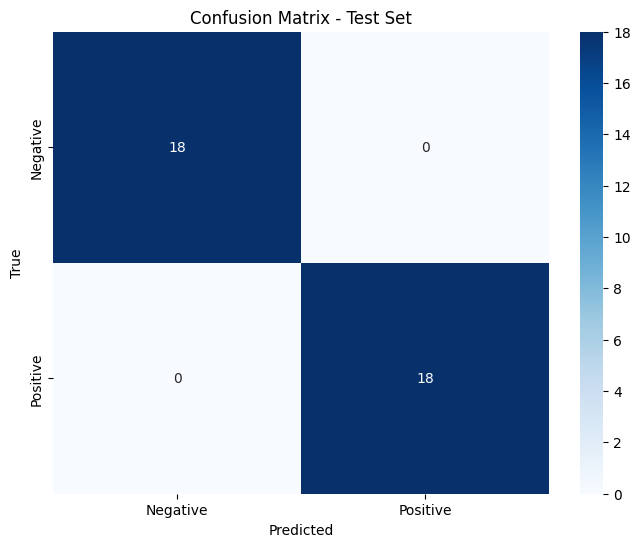

In [ ]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the test set
preds_test = test_pred2
y_test_vectors = merged_df['label']

# Generate confusion matrix
fpr, tpr, thresholds = roc_curve(y_test_vectors, preds_test)
roc_auc = auc(fpr, tpr)

# You can choose a threshold based on your requirements, for example, maximizing the F1 score
optimal_threshold = thresholds[np.argmax(tpr - fpr)]

# Convert probabilities to binary predictions using the optimal threshold
binary_preds_test = (preds_test >= optimal_threshold).astype(int)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_vectors, binary_preds_test)

# Calculate additional metrics
accuracy = accuracy_score(y_test_vectors, binary_preds_test)
precision = precision_score(y_test_vectors, binary_preds_test)
recall = recall_score(y_test_vectors, binary_preds_test)
f1 = f1_score(y_test_vectors, binary_preds_test)

# Print metrics
print('ROC AUC test:', roc_auc)
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Test Set')
plt.show()

#Albert_train

In [30]:
from peft import LoraConfig, TaskType
from transformers import AlbertTokenizerFast,AlbertForSequenceClassification
from peft import get_peft_config, PeftModel, PeftConfig, get_peft_model, LoraConfig, TaskType
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from pathlib import Path
from transformers import BitsAndBytesConfig
from transformers import EarlyStoppingCallback

model_name = "albert-base-v2"
tokenizer =  AlbertTokenizerFast.from_pretrained(model_name)
model = AlbertForSequenceClassification.from_pretrained(model_name, num_labels=1)

print(model)

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


AlbertForSequenceClassification(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768,

In [ ]:
peft_config = LoraConfig(
    r=64,
    lora_alpha=1,
    target_modules=["query", "key", "value"],
    lora_dropout=0.01,
    task_type="SEQ_CLS",
    inference_mode=False,
)
peft_model = get_peft_model(model, peft_config)

X = list(train_data["text"])
y = list(train_data["label"])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)

train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)

args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="steps",
    eval_steps=500,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    seed=0,
    logging_steps=10,
    load_best_model_at_end = True
)

trainer = Trainer(
    model=peft_model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

trainer.train()

In [ ]:
model_save_path = "/content/drive/MyDrive/LLM Parameter/AIbert"
trainer.save_model(model_save_path)

config_save_path = '/content/drive/MyDrive/LLM Parameter/AIbert'
model.config.save_pretrained(config_save_path)

custom dataset

In [ ]:
import zipfile
import os

# Replace 'your_path' with the path where you have the zip file
zip_file_path = '/content/drive/MyDrive/LLM Parameter/albert.zip'
extract_folder = '/content/'

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

In [ ]:
tokenizer = AlbertTokenizerFast.from_pretrained("/content/file_tokenizer_2/content/albert_1")
Chat_test = list(merged_df["text"])

# Tokenize the test data
chat_test_tokenized = tokenizer(Chat_test, padding=True, truncation=True, max_length=512)

# Create torch dataset
chat_test_dataset = Dataset(chat_test_tokenized)

# Load the trained model using AutoModelForSequenceClassification
model_path = "/content/file_3/content/output/checkpoint-10500"
model = AlbertForSequenceClassification.from_pretrained(model_path, num_labels=1, ignore_mismatched_sizes=True)

# Define the test trainer
test_trainer = Trainer(model)

# Make predictions
raw_pred = test_trainer.predict(chat_test_dataset).predictions

# Apply sigmoid activation if necessary
test_pred3 = (torch.tensor(raw_pred)).numpy().ravel()

ROC AUC test: 1.0
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


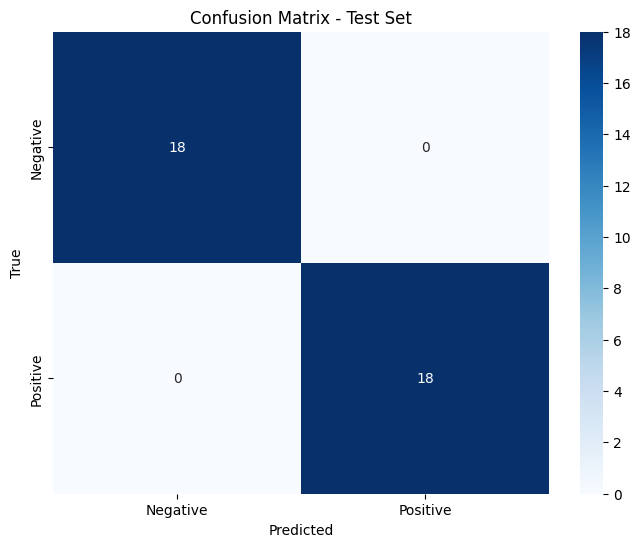

In [ ]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the test set
preds_test = test_pred3
y_test_vectors = merged_df['label']

# Generate confusion matrix
fpr, tpr, thresholds = roc_curve(y_test_vectors, preds_test)
roc_auc = auc(fpr, tpr)

# You can choose a threshold based on your requirements, for example, maximizing the F1 score
optimal_threshold = thresholds[np.argmax(tpr - fpr)]

# Convert probabilities to binary predictions using the optimal threshold
binary_preds_test = (preds_test >= optimal_threshold).astype(int)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_vectors, binary_preds_test)

# Calculate additional metrics
accuracy = accuracy_score(y_test_vectors, binary_preds_test)
precision = precision_score(y_test_vectors, binary_preds_test)
recall = recall_score(y_test_vectors, binary_preds_test)
f1 = f1_score(y_test_vectors, binary_preds_test)

# Print metrics
print('ROC AUC test:', roc_auc)
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Test Set')
plt.show()

#Roberta_train

In [ ]:
from peft import LoraConfig, TaskType
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification
from peft import get_peft_config, PeftModel, PeftConfig, get_peft_model, LoraConfig, TaskType
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from pathlib import Path
from transformers import BitsAndBytesConfig
from transformers import EarlyStoppingCallback

model_name = "roberta-base"
tokenizer = RobertaTokenizerFast.from_pretrained(model_name)
model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=1)

# Define LoRA Config
peft_config = LoraConfig(
 r=16,
 lora_alpha=32,
 target_modules=["query", "key", "value"],
 lora_dropout=0.05,
 bias="none",
 task_type=TaskType.SEQ_CLS, # this is necessary
 inference_mode=True
)

peft_model = get_peft_model(model, peft_config)

X = list(train_data["text"])
y = list(train_data["label"])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)

train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)

args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="steps",
    eval_steps=500,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    seed=0,
    logging_steps=10,
    load_best_model_at_end = True
)

trainer = Trainer(
    model=peft_model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

trainer.train()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Auc Roc
500,0.094600,0.079598,0.996332
1000,0.074300,0.065000,0.997834


Step,Training Loss,Validation Loss,Auc Roc
500,0.094600,0.079598,0.996332
1000,0.074300,0.065000,0.997834
1500,0.064600,0.059473,0.998138
2000,0.087100,0.074060,0.998394
2500,0.051900,0.046123,0.998442
3000,0.079800,0.057364,0.998527
3500,0.060900,0.061363,0.998589
4000,0.052700,0.052245,0.998648


TrainOutput(global_step=4000, training_loss=0.08105555037409067, metrics={'train_runtime': 1146.6862, 'train_samples_per_second': 92.521, 'train_steps_per_second': 11.566, 'total_flos': 8564584415232000.0, 'train_loss': 0.08105555037409067, 'epoch': 0.9})

In [ ]:
trainer.model.save_pretrained('model')
!zip -r /content/model2.zip /content/model

tokenizer.save_pretrained('token')
!zip -r /content/token2.zip /content/token

  adding: content/model/ (stored 0%)
  adding: content/model/model.safetensors (deflated 10%)
  adding: content/model/config.json (deflated 50%)
  adding: content/model/README.md (deflated 66%)
  adding: content/model/adapter_config.json (deflated 47%)
  adding: content/model/adapter_model.bin (deflated 35%)
  adding: content/token/ (stored 0%)
  adding: content/token/tokenizer.json (deflated 72%)
  adding: content/token/special_tokens_map.json (deflated 52%)
  adding: content/token/tokenizer_config.json (deflated 76%)
  adding: content/token/merges.txt (deflated 53%)
  adding: content/token/vocab.json (deflated 59%)


In [ ]:
import zipfile
import os

# Replace 'your_path' with the path where you have the zip file
zip_file_path = '/content/drive/MyDrive/LLM Parameter/robert.zip'
extract_folder = '/content/'

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

In [ ]:
tokenizer = RobertaTokenizerFast.from_pretrained("/content/roberta_1")
Chat_test = list(merged_df["text"])

# Tokenize the test data
chat_test_tokenized = tokenizer(Chat_test, padding=True, truncation=True, max_length=512)

# Create torch dataset
chat_test_dataset = Dataset(chat_test_tokenized)

# Load the trained model using AutoModelForSequenceClassification
model_path = "/content/file_2/content/output/checkpoint-3000"
model = RobertaForSequenceClassification.from_pretrained(model_path, num_labels=1, ignore_mismatched_sizes=True)

# Define the test trainer
test_trainer = Trainer(model)

# Make predictions
raw_pred = test_trainer.predict(chat_test_dataset).predictions

# Apply sigmoid activation if necessary
test_pred4 = (torch.tensor(raw_pred)).numpy().ravel()

ROC AUC test: 0.9753086419753086
Accuracy: 0.9444444444444444
Precision: 1.0
Recall: 0.8888888888888888
F1 Score: 0.9411764705882353


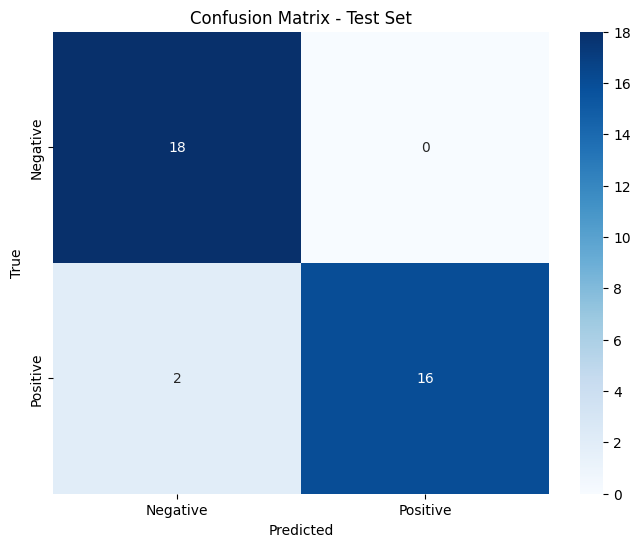

In [ ]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the test set
preds_tes = test_pred4
y_test_vectors = merged_df['label']

# Generate confusion matrix
fpr, tpr, thresholds = roc_curve(y_test_vectors, preds_test)
roc_auc = auc(fpr, tpr)

# You can choose a threshold based on your requirements, for example, maximizing the F1 score
optimal_threshold = thresholds[np.argmax(tpr - fpr)]

# Convert probabilities to binary predictions using the optimal threshold
binary_preds_test = (preds_test >= optimal_threshold).astype(int)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_vectors, binary_preds_test)

# Calculate additional metrics
accuracy = accuracy_score(y_test_vectors, binary_preds_test)
precision = precision_score(y_test_vectors, binary_preds_test)
recall = recall_score(y_test_vectors, binary_preds_test)
f1 = f1_score(y_test_vectors, binary_preds_test)

# Print metrics
print('ROC AUC test:', roc_auc)
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Test Set')
plt.show()

#앙상블

In [ ]:
average_pred = (test_pred1 + test_pred2 + test_pred3 + test_pred4) / 4

ROC AUC test: 0.9753086419753086
Accuracy: 0.9444444444444444
Precision: 1.0
Recall: 0.8888888888888888
F1 Score: 0.9411764705882353


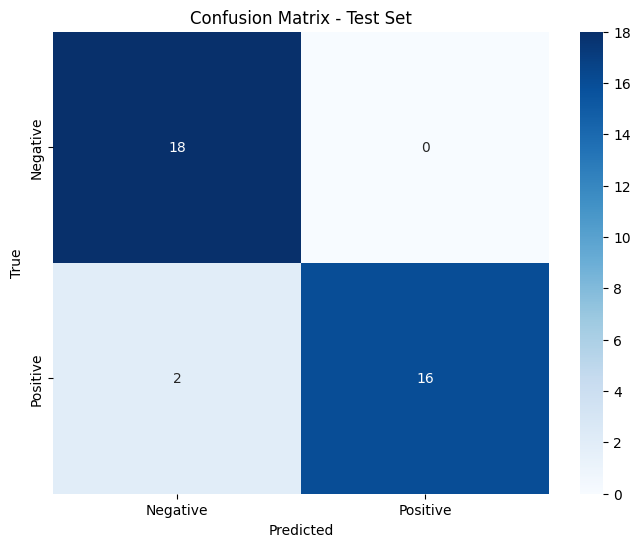

In [ ]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the test set
preds_tes = average_pred
y_test_vectors = merged_df['label']

# Generate confusion matrix
fpr, tpr, thresholds = roc_curve(y_test_vectors, preds_test)
roc_auc = auc(fpr, tpr)

# You can choose a threshold based on your requirements, for example, maximizing the F1 score
optimal_threshold = thresholds[np.argmax(tpr - fpr)]

# Convert probabilities to binary predictions using the optimal threshold
binary_preds_test = (preds_test >= optimal_threshold).astype(int)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_vectors, binary_preds_test)

# Calculate additional metrics
accuracy = accuracy_score(y_test_vectors, binary_preds_test)
precision = precision_score(y_test_vectors, binary_preds_test)
recall = recall_score(y_test_vectors, binary_preds_test)
f1 = f1_score(y_test_vectors, binary_preds_test)

# Print metrics
print('ROC AUC test:', roc_auc)
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Test Set')
plt.show()